# What Is Optical Coherence Tomography?

Retinal optical coherence tomography (OCT) is an imaging technique used to capture high-resolution cross sections of the retinas of living patients. 

Approximately **30 million OCT scans are performed each year**, and the analysis and interpretation of these images takes up a significant amount of time (Swanson and Fujimoto, 2017).

With OCT, your ophthalmologist can see each of the retina’s distinctive layers.  This allows your ophthalmologist to map and measure their thickness. These measurements help with diagnosis. They also provide treatment guidance for glaucoma and diseases of the retina. These retinal diseases include age-related macular degeneration (AMD) and diabetic eye disease.

Sources: 

https://www.kaggle.com/paultimothymooney/kermany2018/home 

https://www.aao.org/eye-health/treatments/what-is-optical-coherence-tomography

## Our DataSet

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (NORMAL,CNV,DME,DRUSEN). There are 84,495 X-Ray images (JPEG) and 4 categories (NORMAL,CNV,DME,DRUSEN).

Source: https://data.mendeley.com/datasets/rscbjbr9sj/2 

## Our Task
Given the nature of our dataset, we will build an **image-classifier** to help classify 
1. Normal
2. CNV - Choroidal Neovascularization
3. DME - Diabetic macular edema
4. DRUSEN

### Our Model 
We will be experimenting with a **DenseNet** Architecture, by utilizing the **FastAI** Framework that works on top of **PyTorch** 

### Our Methods
We will first make sure we load up all the appropriate libraries and packages, then we will explore the data by creating a DataBunch object (FastAI), and eventually begin with a very simple **DenseNet161** Model.

We will then end with a **conclusion & further work** to better improve the model

## Importing & Downloading Our Data

In [ ]:
# !pip install kaggle --upgrade
# !pip install fastai

In [1]:
from fastai import *
from fastai.vision import *

import torch
from torchvision.models import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
# checking if enabled
torch.backends.cudnn.enabled == True

True

In [ ]:
# # configuring kaggle
# !mkdir .kaggle 

# cred = json.dumps({"username":"USERNAME","key":"KEY"}) 
# with open('.kaggle/kaggle.json', 'w') as f:
#     f.write(cred)

# # Configuring the file - we will run this twice (second time next block)
# !cp .kaggle/kaggle.json ~/.kaggle/kaggle.json
# !kaggle config set -n path -v{/notebooks/course-v3/nbs/dl1}

In [ ]:
# # run for second time
# !cp .kaggle/kaggle.json ~/.kaggle/kaggle.json
# !kaggle config set -n path -v{/notebooks/course-v3/nbs/dl1}

In [ ]:
# # making private
# !chmod 600 /root/.kaggle/kaggle.json

In [3]:
# Making directory
!mkdir retinal_data

In [57]:
path = '/notebooks/course-v3/nbs/dl1/retinal_data'

In [56]:
!kaggle datasets download -d paultimothymooney/kermany2018 -f OCT2017.zip -p {path}

100%|██████████████████████████████████████▉| 5.43G/5.43G [01:29<00:00, 100MB/s]
100%|██████████████████████████████████████| 5.43G/5.43G [01:29<00:00, 65.5MB/s]


In [58]:
os.listdir(path)

['OCT2017.zip']

In [59]:
# unzipping folder
!unzip -q -n {path}/OCT2017.zip -d {path}

warning [/notebooks/course-v3/nbs/dl1/retinal_data/OCT2017.zip]:  4294967296 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  4294967296
  (attempting to re-compensate)
file #122249:  bad zipfile offset (local header sig):  51410
  (attempting to re-compensate)


In [61]:
!rm -rf {path}/OCT2017.zip
!rm -rf {path}/__MACOSX

os.listdir(path)

['OCT2017 ']

In [62]:
images_path = f'{path}/OCT2017 '
os.listdir(images_path)

['.DS_Store', 'val', 'test', 'train']

In [63]:
!rm -rf {images_path}/.DS_Store

os.listdir(images_path)

['.DS_Store', 'val', 'test', 'train']

In [79]:
!mv /notebooks/course-v3/nbs/dl1/retinal_data/OCT2017\  /notebooks/course-v3/nbs/dl1/retinal_data/images

In [117]:
images_path = 'retinal_data/images'
os.listdir(images_path)

['test', 'valid', 'train']

In [84]:
!rm -rf retinal_data/images/.DS_Store
os.listdir(images_path)

['val', 'test', 'train']

In [95]:
images_path = 'retinal_data/images'

# renaming val to valid
!mv {images_path}/val {images_path}/valid
os.listdir(images_path)

['test', 'valid', 'train']

By inspecting the **Data** we have downloaded, you will notice that our **Valid** folder only contains 32 images. From my experience this is not enough for validation. 

You will usually go for a **80/20** train/valid split. 

So we will delete both **valid & test** folders, and use **train** folder to build a **validation set**. This is all very easy thanks to the FastAI library

In [125]:
!rm -rf {images_path}/valid
!rm -rf {images_path}/test
!mv {images_path}/train {images_path}/images # renaming train to image

NameError: name 'image_path' is not defined

In [126]:
os.listdir(images_path)

['images']

In [129]:
count = 0

for f in os.listdir(f'{images_path}/images'):
    count += len(os.listdir(f'{images_path}/images/{f}'))
    
print(f'There are {count} images')

There are 83484 images


In [130]:
# Converting to FastAI Path Object
path = Path(images_path)
path.ls()

[PosixPath('retinal_data/images/images')]

## Creating DataBunch Object

In [131]:
# Setting data augmentation
tfms_ = get_transforms(flip_vert=False, max_rotate=0.0, max_zoom=.1, max_warp=0.0)

seed = np.random.seed(42)

src = (ImageItemList.from_folder(path)
                    .random_split_by_pct(0.2, seed)
                    .label_from_folder())

def get_data(image_size, batch_size):
    data = (src.transform(tfms=tfms_, size=image_size)
               .databunch(num_workers=2, bs=batch_size).normalize(imagenet_stats))
    
    return data

In [132]:
data = get_data(128, 64)
data

ImageDataBunch;

Train: LabelList
y: CategoryList (66788 items)
[Category NORMAL, Category NORMAL, Category NORMAL, Category NORMAL, Category NORMAL]...
Path: retinal_data/images
x: ImageItemList (66788 items)
[Image (3, 496, 768), Image (3, 496, 768), Image (3, 496, 768), Image (3, 496, 768), Image (3, 496, 768)]...
Path: retinal_data/images;

Valid: LabelList
y: CategoryList (16696 items)
[Category CNV, Category NORMAL, Category CNV, Category DME, Category NORMAL]...
Path: retinal_data/images
x: ImageItemList (16696 items)
[Image (3, 496, 512), Image (3, 512, 512), Image (3, 496, 512), Image (3, 496, 768), Image (3, 496, 512)]...
Path: retinal_data/images;

Test: None

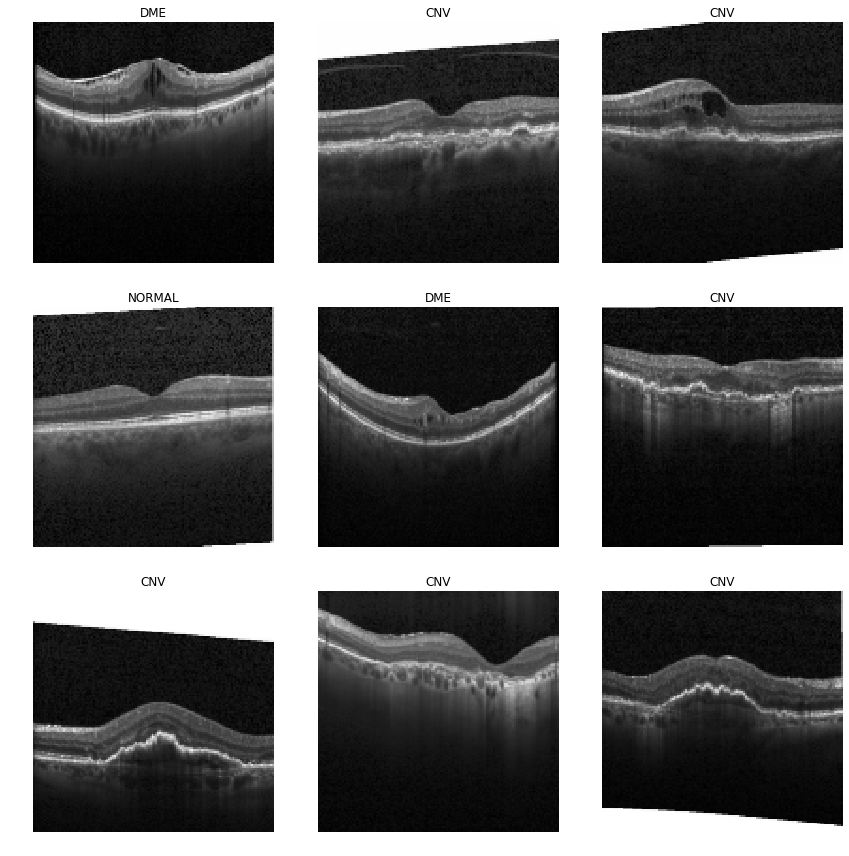

In [133]:
data.show_batch(rows=3)

## Building Our Model
We will be using a DenseNet161 Architecture

In [134]:
# Architecture
arch_densenet = densenet161

In [135]:
learn = create_cnn(data, arch_densenet, metrics=[error_rate, accuracy])

/opt/conda/envs/fastai/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


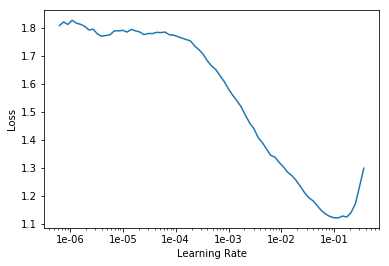

In [136]:
learn.lr_find()
learn.recorder.plot()

In [137]:
lr = 7e-3

In [138]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.240323,0.252017,0.075767,0.924233
2,0.187383,0.166340,0.057259,0.942741
3,0.144086,0.119818,0.039890,0.960110
4,0.125696,0.104390,0.035218,0.964782
5,0.103331,0.101526,0.034140,0.965860


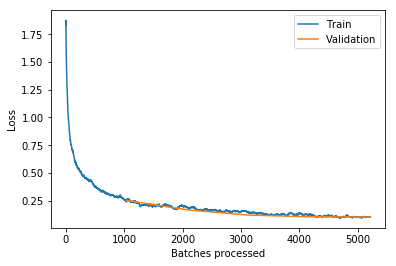

In [139]:
learn.recorder.plot_losses()

In [145]:
# learn.freeze()
learn.save('stage-1')

In [146]:
# unfreezing layers
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


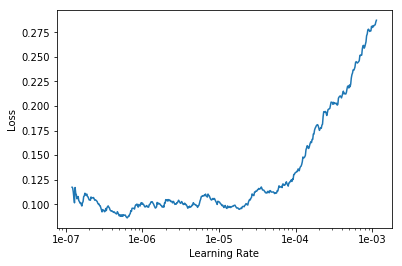

In [143]:
# finding optimal learning rates
learn.lr_find(num_it=1000)
learn.recorder.plot()

In [147]:
lr2 = 3e-7

In [148]:
learn.fit_one_cycle(3, slice(lr2, lr/5))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.103657,0.101978,0.034260,0.965740
2,0.102907,0.102317,0.034140,0.965860
3,0.094940,0.100340,0.034080,0.965920


In [149]:
learn.save('stage-2')

## Conclusions & Next Steps
Because we are running our models on a **p4000** via www.paperspace.com, we are limited to **8gb RAM** for our graphic card. 

If I was training on a more memory intense card, I would:

* Create new Databunch Object - larger image size
* Repeat:
    * Freeze all layers, will keep last few layer unfrozen
    * Find optimal learning rate
    * Train for 10 epochs with optimal learning rate
    * Unfreeze all layers
    * Find optimal learning rates
    * Apply differential learning rates
* Do Test Time Augmentation 
* Test in Inference